# Homework

## Problem 1

In [1]:
# Import what we need for the job...
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras_tqdm import TQDMNotebookCallback
# Visualization
from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
# Preprocessing - grab lines from the file
with open('/nfshome/sandbox/gutenberg_example/PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')
# Paragraphs are separated by blank
# lines -> just drop those lines...
text = []
for i in range(len(lines)):
    if lines[i] != '':
        text = text + [lines[i]]
min_length = max([len(i) for i in text])

In [3]:
# Unique characters - precalculated
with open('/nfshome/sandbox/gutenberg_example/unique_chars.txt', 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')
# Integer code to symbol
itos = ['','',' ']
for i in lines:
    itos = itos + [i]
# Symbol to integer code
stoi = dict()
stoi['STOP'] = 0
stoi['START'] = 1
for i in range(2,len(itos)):
    stoi[itos[i]] = i

In [4]:
# Longest sentence - plus start/stop
max(len(i) for i in text)+2

76

In [5]:
# functions to encode and decode
def encode_seq(x,mapping,min_length=0):
# String to one-hot
    y = [mapping['START']]
    for i in list(x):
        y = y + [mapping[i]]
    y = y + [mapping['STOP']]
    # Stop-padding - handled elsewhere...
    while len(y) < min_length:
        y = y + [mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))

def decode_seq(x,mapping):
    # One-hot to string
    y = []
    for i in x:
        y = y + [mapping[np.argmax(i)]]
    return ''.join(y)

In [6]:
# Test an ecoding-decoding cycle on the first line...
temp = encode_seq(text[0],stoi)
temp = decode_seq(temp,itos)
temp

'It is a truth universally acknowledged, that a single man in possession'

In [7]:
# Encode that data
dataX = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:] = temp
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:] = temp

In [8]:
X = dataX[0:dataX.shape[0]-1,:,:]
Y = dataY[1:dataY.shape[0],:,:]
preY = Y[:,0:Y.shape[1]-1,:]
postY = Y[:,1:Y.shape[1],:]

In [9]:
nlines = 50
X = X[0:nlines,:,:]
Y = Y[0:nlines,:,:]
preY = preY[0:nlines,:,:]
postY = postY[0:nlines,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(50, 76, 71)
(50, 76, 71)
(50, 75, 71)
(50, 75, 71)


In [10]:
# Size of the gestalt, context representations...
hidden_size = (max(len(i) for i in text)+2)*3
## Encoder Construction
# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)
# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)
# Compile it...
model.compile(loss=keras.losses.categorical_crossentropy,
                        optimizer=keras.optimizers.Adam(),
                        metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 71)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 228), (None, 273600      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 228),  273600      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [12]:
batch_size = 5
epochs = 300
history = model.fit([X,preY], postY,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    callbacks=[TQDMNotebookCallback()])
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

50/50 [==============================] - 1s 14ms/step
Accuracy: 74.21333312988281 %


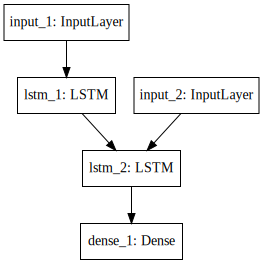

In [13]:
# Visualization - wish we could see the recurrent weights!
SVG(model_to_dot(model).create(prog='dot', format='svg'))

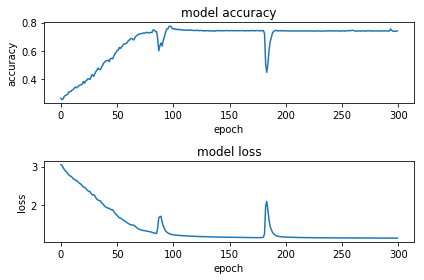

In [15]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [16]:
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                        initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
    [decoder_input] + decoder_states_input,
    [decoder_output] + decoder_states)

In [17]:
# Get the gestalt context for the input sequence(s)
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
# Prep a starting token...
token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
token

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [18]:
# Iterate - teacher forcing through each line
for i in range(0,nlines):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[i:i+1,:,:])
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))

Txt: of a good fortune, must be in want of a wife.
Net: of a good fortune, must be in want of a wife. o  any 
Txt: However little known the feelings or views of such a man may be on his
Net: However little known the feelings or views of such a man may be on his
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: first entering a neighbourhood, this truth is so well fixed in the minds
Txt: of the surrounding families, that he is considered the rightful property
Net: of the surrounding families, that he is considered the rightful property
Txt: of some one or other of their daughters.
Net: of some one or other of their daughters. o  any se
Txt: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Net: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Txt: Netherfield Park is let at last?"
Net: Netherfield Park is let at last?" o  any se
Txt: Mr. Bennet replied that he had not.
Net: Mr. Bennet replied that he had not

In [19]:
# Iterate - but no teaching forcing past first line...
# Get the gestalt context for the input sequence
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
for i in range(0,nlines):
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context = encoder_model.predict(result)

Txt: of a good fortune, must be in want of a wife.
Net: of a good fortune, must be in want of a wife. o  any 
Txt: However little known the feelings or views of such a man may be on his
Net: ewcomers. Indeed you must go, for it will be impossible for _us_ to
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: visit him if you do not." o  any se
Txt: of the surrounding families, that he is considered the rightful property
Net: of a good fortune, must be in want of a wife. o  any 
Txt: of some one or other of their daughters.
Net: ewcomers. Indeed you must go, for it will be impossible for _us_ to
Txt: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Net: visit him if you do not." o  any se
Txt: Netherfield Park is let at last?"
Net: of a good fortune, must be in want of a wife. o  any 
Txt: Mr. Bennet replied that he had not.
Net: ewcomers. Indeed you must go, for it will be impossible for _us_ to
Txt: "But it is," returned she; "fo

## Problem 2

In [61]:
# Preprocessing - grab words from the file
import re
with open('/nfshome/sandbox/gutenberg_example/PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
            # words = f.read().split('\n')
            words = re.findall(r"[\w']+|[.,!?;]", f.read())
# Paragraphs are separated by blank
# lines -> just drop those lines...
text = []
for i in range(len(words)):
    if words[i] != '':
        text = text + [words[i]]
min_length = max([len(i) for i in text])

In [62]:
# Unique characters - precalculated
with open('/nfshome/sandbox/gutenberg_example/unique_chars.txt', 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')
# Integer code to symbol
itos = ['','',' ']
for i in lines:
    itos = itos + [i]
# Symbol to integer code
stoi = dict()
stoi['STOP'] = 0
stoi['START'] = 1
for i in range(2,len(itos)):
    stoi[itos[i]] = i

In [63]:
# Longest word - plus start/stop
max(len(i) for i in text)+2

19

In [122]:
# Test an ecoding-decoding cycle on the first line...
temp = encode_seq(text[0],stoi)
temp = decode_seq(temp,itos)
temp

'It'

In [124]:
text[0]

'It'

In [132]:
for i in text:
    if len(i) > 16:
        print(i)

disinterestedness
misrepresentation
communicativeness


In [133]:
# Test an ecoding-decoding cycle on the first line...
for i in range(0,10):
    temp = encode_seq(text[i],stoi)
    temp = decode_seq(temp,itos)
    print(temp)

It
is
a
truth
universally
acknowledged
,
that
a
single


In [92]:
# Encode that data
dataX = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:] = temp
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY = np.ones([len(text),max([len(i) for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp = encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:] = temp

In [93]:
X = dataX[0:dataX.shape[0]-1,:,:]
Y = dataY[1:dataY.shape[0],:,:]
preY = Y[:,0:Y.shape[1]-1,:]
postY = Y[:,1:Y.shape[1],:]

In [128]:
nwords = 500
X = X[0:nwords,:,:]
Y = Y[0:nwords,:,:]
preY = preY[0:nwords,:,:]
postY = postY[0:nwords,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(500, 19, 71)
(500, 19, 71)
(500, 18, 71)
(500, 18, 71)


In [143]:
# Size of the gestalt, context representations...
hidden_size = (max(len(i) for i in text)+2)*60
## Encoder Construction
# Make the layers
encoder_input = keras.layers.Input(shape=(None, X.shape[2]))
encoder_hidden = keras.layers.LSTM(hidden_size, return_state=True)
# Tie the hidden layer to the input layer (passed in)
encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [enc_state_h, enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input = keras.layers.Input(shape=(None, preY.shape[2]))
decoder_hidden = keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                initial_state=encoder_states)
decoder_dense = keras.layers.Dense(postY.shape[2], activation='softmax')
# Connect output to hidden
decoder_output = decoder_dense(decoder_hidden_output)
# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model = keras.Model([encoder_input, decoder_input], decoder_output)
# Compile it...
model.compile(loss=keras.losses.categorical_crossentropy,
                        optimizer=keras.optimizers.Adam(),
                        metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, None, 71)     0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, None, 71)     0                                            
__________________________________________________________________________________________________
lstm_26 (LSTM)                  [(None, 1140), (None 5526720     input_32[0][0]                   
__________________________________________________________________________________________________
lstm_27 (LSTM)                  [(None, None, 1140), 5526720     input_33[0][0]                   
                                                                 lstm_26[0][1]                    
          

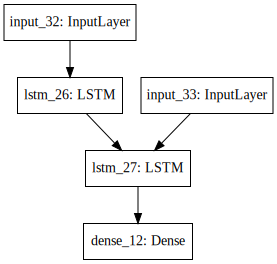

In [144]:
# Visualization - wish we could see the recurrent weights!
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [145]:
batch_size = nwords
epochs = 600
history = model.fit([X,preY], postY,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    callbacks=[TQDMNotebookCallback()])
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')

500/500 [==============================] - 6s 12ms/step
Accuracy: 27.68888852596283 %


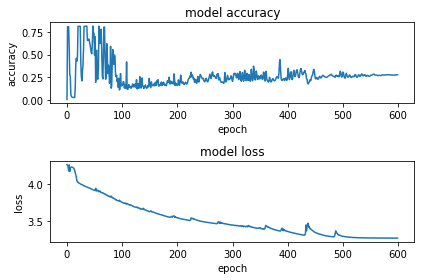

In [146]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [147]:
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model = keras.Model(encoder_input, encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h = keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c = keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                        initial_state=decoder_states_input)
decoder_states = [decoder_state_h, decoder_state_c]
# Connect output to hidden(s)
decoder_output = decoder_dense(decoder_hidden_output)
decoder_model = keras.Model(
    [decoder_input] + decoder_states_input,
    [decoder_output] + decoder_states)

In [148]:
# Get the gestalt context for the input sequence(s)
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
# Prep a starting token...
token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
token

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [149]:
# Iterate - teacher forcing through each line
for i in range(0,nwords):
    # Get the gestalt context for the input sequence(s)
    context = encoder_model.predict(X[i:i+1,:,:])
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))

Txt: is
Net: is
Txt: a
Net: 
Txt: truth
Net: e
Txt: universally
Net: is
Txt: acknowledged
Net: acknowledged
Txt: ,
Net: ,
Txt: that
Net: i
Txt: a
Net: he
Txt: single
Net: e
Txt: man
Net: man
Txt: in
Net: of
Txt: possession
Net: t
Txt: of
Net: fore
Txt: a
Net: 
Txt: good
Net: e
Txt: fortune
Net: fortune
Txt: ,
Net: ro
Txt: must
Net: i
Txt: be
Net: is
Txt: in
Net: nthing
Txt: want
Net: t
Txt: of
Net: to
Txt: a
Net: 
Txt: wife
Net: e
Txt: .
Net: mpatiently
Txt: However
Net: o
Txt: little
Net: little
Txt: known
Net: known
Txt: the
Net: the
Txt: feelings
Net: rthing
Txt: or
Net: or
Txt: views
Net: ingle
Txt: of
Net: of
Txt: such
Net: 
Txt: a
Net: ase
Txt: man
Net: e
Txt: may
Net: of
Txt: be
Net: end
Txt: on
Net: nthing
Txt: his
Net: ond
Txt: first
Net: 
Txt: entering
Net: entering
Txt: a
Net: a
Txt: neighbourhood
Net: e
Txt: ,
Net: ,
Txt: this
Net: i
Txt: truth
Net: truth
Txt: is
Net: is
Txt: so
Net: 
Txt: well
Net: e
Txt: fixed
Net: fixed
Txt: in
Net: in
Txt: the
Net: t
Txt: minds
Net: rth

In [150]:
# Iterate - but no teaching forcing past first line...
# Get the gestalt context for the input sequence
i = 0
context = encoder_model.predict(X[i:i+1,:,:])
for i in range(0,nwords):
    # Prep a starting token...
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c = decoder_model.predict([token]+context)
        token = np.round(out)
        context = [h,c]
        result[:,x,:] = token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context = encoder_model.predict(result)

Txt: is
Net: is
Txt: a
Net: .
Txt: truth
Net: o
Txt: universally
Net: by
Txt: acknowledged
Net: xtraordinary
Txt: ,
Net: it
Txt: that
Net: .
Txt: a
Net: o
Txt: single
Net: by
Txt: man
Net: xtraordinary
Txt: in
Net: it
Txt: possession
Net: .
Txt: of
Net: o
Txt: a
Net: by
Txt: good
Net: xtraordinary
Txt: fortune
Net: it
Txt: ,
Net: .
Txt: must
Net: o
Txt: be
Net: by
Txt: in
Net: xtraordinary
Txt: want
Net: it
Txt: of
Net: .
Txt: a
Net: o
Txt: wife
Net: by
Txt: .
Net: xtraordinary
Txt: However
Net: it
Txt: little
Net: .
Txt: known
Net: o
Txt: the
Net: by
Txt: feelings
Net: xtraordinary
Txt: or
Net: it
Txt: views
Net: .
Txt: of
Net: o
Txt: such
Net: by
Txt: a
Net: xtraordinary
Txt: man
Net: it
Txt: may
Net: .
Txt: be
Net: o
Txt: on
Net: by
Txt: his
Net: xtraordinary
Txt: first
Net: it
Txt: entering
Net: .
Txt: a
Net: o
Txt: neighbourhood
Net: by
Txt: ,
Net: xtraordinary
Txt: this
Net: it
Txt: truth
Net: .
Txt: is
Net: o
Txt: so
Net: by
Txt: well
Net: xtraordinary
Txt: fixed
Net: it
Txt: in

## Problem 3